# Example: NormalisEd Radon Transform Damage detection, applied to a GeoTIFF image of Pine Island Glacer
2022 - Maaike Izeboud - Delft University of Technology, Department of Geoscience and Remote Sensing

#### About
This notebook provides a step-by-step example of the NormalisEd Radon Transform Damage detection (NeRD) method, as detailed in the publiction "Damage Detection on Antarctic Ice Shelves using the Normalised Radon Transform" by M. Izeboud and S. Lhermitte (2022) in Remote Sensing of Environment (in review, doi: [to be included]).

#### The method
The method consists of the following steps:
* Read an image; convert to grayscale
* Cut image into separate windows of NxN pixels
* Apply Normalised Radon Transform to each window, yielding a single crevasse signal value ($\sigma_{crev}$) and orientation ($\theta_{crev}$) for every window
* Calculate damage orientation ($\alpha_c$) and signal ($\hat{D}$)
* Save output as netCDF and/or geotiff.

Note that:
- Files and parameters should be provided in a configuration file.
- The method is also provided as a python script, which can be run from a local terminal (or cluster) as: 
 `python path/to/main.py path/to/config.ini path/to/image.tiff`

### Packages and Paths

In [2]:

print(os.getcwd()) # path/to/git/repo/python/notebooks
os.chdir('../../') # go to parent, path/to/git/repo/
this_dir = os.getcwd() 
path_to_modules = os.path.join(this_dir,'python/scripts/')
os.chdir(path_to_modules)

import nerd
import sys
import configparser
import os
import time
import numpy as np
import json
import xarray as xr

from pathos.multiprocessing import ProcessingPool as Pool

xr.set_options(keep_attrs=True)


/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/PhD/CrevasseDetection/NormalisedRadonTransform/python/notebooks


In [1]:
#!/usr/bin/env python3.9


def main(configFile,imageFile):

    ''' -------
    Configuration 
    -----------'''
    
    if configFile is None:
        raise NameError('No config file specified. Run script as "python main.py /path/to/config_file.ini /path/to/image.tif"')
    else:
        config = configparser.ConfigParser()
        config.read(os.path.join(configFile))

    if imageFile is None:
        raise NameError('No image file specified. Run script as "python main.py /path/to/config_file.ini /path/to/image.tif"')
    else:
        print('img ' , imageFile)
        imPath,imName = os.path.split(imageFile) #  split file from path
        if not imPath:
            raise NameError('No path to image file provided. Provide file as ./path/to/image.tif')
    
    path2threshold = config['PATHS']['path2files']
    threshold_fname= config['PATHS']['threshold_fname']

    img_res = int(config['DATA']['imRes'])
    source = config['DATA']['source']
    dbmin = int(config['DATA']['img_bounds_min'])
    dbmax = int(config['DATA']['img_bounds_max'])

    wsize = int(config['NERD']['window_size_px'])
    cores= int(config['NERD']['cores'])
    window_range = wsize*img_res


    # -- settings following from config

    outPath = os.path.join(imPath,'damage_detection')
    if not os.path.isdir(outPath):
        os.mkdir(outPath)

    path2save = os.path.join(outPath, 'geotiffs_python/')
    if not os.path.isdir(path2save):
        os.mkdir(path2save)


    ''' -------
    Load Image 
    -----------'''


    fname_out = imName[:-4] + '_output_' + str(wsize) + 'px' # [imName_output_Npx]

    if os.path.exists(os.path.join(outPath,fname_out + '.nc')):
        print('Output already exists for {} -- stop'.format(fname_out))

    else:

        print('---- \n  Read img ' , imName)


        # -- read img to grayscale
        img = nerd.read_img_to_grayscale(imPath, imName, dbmin, dbmax) # (y,x)

        # -- check img resolution
        dx = np.unique(img['x'].diff(dim='x'))
        if len(dx) == 1:
            if not dx[0] == img_res:
                raise Exception("Configured img resolution ({}) does not equal grid resolution ({})".format(img_res,dx[0]))
        else:
            raise Exception("Inconsistent grid spacing; dx values are {}".format(dx)) 


        # -- cut windows
        print('.. processing img of res {}m on {}px windows'.format(img_res,wsize))
        windows_df = nerd.cut_img_to_windows(img,wsize=wsize) # (x_win, y_win, sample)



        ''' -------
        MultiProcess NeRD method with Multi Processing
        -----------'''

        start_time = time.time()

        # split data in parts (equal to N cores) --> converts to list
        windows_split = np.array_split(windows_df, cores, axis=2) 
        print( 'Split img windows into {} parts of {} windows for multi-processing '.format(cores, [part.shape[2] for part in windows_split] ) )

        # Map function over each split data-part, and stack the parts back together
        with Pool(cores) as pool: # create the multiprocessing pool 
            print('started pool.map on df_split')
            pool_out = pool.map( nerd.process_img_windows, windows_split) # list of arrays with shape (n_samples_split,8)
            df_out = np.concatenate( pool_out ) # array with (samples,8)


        pool.close()
        pool.join()
        pool.clear()    


        print('.. done with pool.map after: {:.2f}hour'.format((time.time() - start_time)/(60*60)) )


        ''' -------
        Assemble results back to data array
        -----------'''


        results = df_out # array with (samples,8)

        # put back to xarray dataArray to convert back to 2D

        da_result = xr.DataArray(results,
                                 dims=("sample","out"), 
                                 coords=(windows_df["sample"], range(8)), 
                                 name="output", 
                                 attrs=img.attrs, indexes=img.indexes) 

        da_result.attrs['long_name'] = 'Output_NeRD'
        da_result.attrs['descriptions'] = '[theta_1,signal_1, theta_2,signal_2, theta_3,signal_3, theta_4,signal_4]'


        # back to 2D
        da_result = da_result.unstack('sample').transpose("y","x","out")
        # print('..Reshaped output {} back to (x,y,out): {}'.format(df_out.shape,da_result.shape))
        # da_result.attrs

        da_result.attrs['img_res'] = img_res
        da_result.attrs['window_size(px)'] = wsize
        da_result.attrs['window_range(m)'] = window_range
        da_result.attrs['crs']='EPSG:3031'


        ''' -------
        Save to netCDF
        -----------'''
        da_result.to_netcdf(os.path.join(outPath,fname_out+'.nc'))

        print('.. output data saved to {}{}------ '.format(outPath,fname_out))

        ''' -------
        Processing of output 
        - Calculate dmg from crevasse signal value
        - Radon angle to crevasse aangle
        - calculate delta_alpha and delta_thetap?
        -----------'''

        alpha_c = da_result.isel(out=0) - 90 # alpha_c = theta_NERD - 90, such that alpha_c [-90 to 90]
        crevSig = da_result.isel(out=1)

        # convert crevSig to dmg
        dmg, threshold = nerd.crevsig_to_dmg(crevSig, os.path.join(path2threshold,threshold_fname), source, img_res,wsize)

        ''' -------
        Save to geotiffs
        -----------'''

        fname_crevSig = fname_out + '_crevSig'
        fname_alpha_c = fname_out + '_alphaC'

        fname_dmg = fname_out + '_dmg'

        # export a single band to Cloud Optimzed geotiff
        alpha_c.rio.to_raster( os.path.join(path2save, fname_alpha_c + '.tif'),driver="COG")
        crevSig.rio.to_raster( os.path.join(path2save, fname_crevSig + '.tif'),driver="COG")

        if threshold is not None:
            dmg.where(dmg>0).rio.to_raster( os.path.join(path2save, fname_dmg + '.tif'),driver="COG")


        print(' ----- geotiffs saved to {}------\n '.format(path2save))

    print(' Done \n')
    

# if __name__ == '__main__':
#     #  Run script as "python path/to/main.py /path/to/config_file.ini /path/to/image.tif"
        
#     # retrieve config and image file name from command line
#     config = sys.argv[1] if len(sys.argv) > 1 else None
#     imageFile = sys.argv[2] if len(sys.argv) > 2 else None
#     # run script
#     main(config,imageFile)

ModuleNotFoundError: No module named 'nerd'

# KLAD

In [ ]:

''' -------
Load Image 
-----------'''

# open image and convert RGB to Grayscale
img = rioxr.open_rasterio(os.path.join(imPath , imName))
img_rgb = img.transpose("y","x","band")
img_gray = xr.DataArray(data=rgb2gray(img_rgb), coords=(img["y"], img["x"] ), dims=("y","x"), name="gray_image", attrs=img.attrs, indexes=img.indexes)#, fastpath=False)
img_gray.attrs["long_name"] = "grayscale"

# Set up window construct
r = img_gray.rolling(x=wsize, y=wsize, min_periods=None)
rolling_da = r.construct(x="x_win", y="y_win", stride=wsize) # (y x ywin xwin)
print(rolling_da.shape)
print(rolling_da.dims)

# issue: cutouts along the edge of the original raster are filled with NaN's: drop NaN-containing windows
windows = rolling_da.stack(sample=["x", "y"],)
windows = windows.dropna(dim="sample",how="any")
print(windows.shape)

windows_1D = windows # (x,y,sample)
windows_2D = windows.unstack('sample').transpose("y","x","x_win","y_win")
windows_2D.shape



''' -------
MultiProcess NeRD method with Multi Processing
-----------'''

start_time = time.time()

print('windows_1D', windows_1D.shape)
test_N_samples = 2000
df = windows_1D[:,:,:test_N_samples] # (xwin,ywin, N)
df = windows_1D[:,:,:] # (xwin,ywin, N)
# df = windows_1D # (xwin,ywin, N)

print('data input', df.shape)


cores=5; # cores=mp.cpu_count() # intended amount of cores
print(df.shape[2] % cores)

# while df.shape[2] % cores != 0: # split parts must be equal in size for easy np.stack() of results later on.
#     cores -= 1 # adjust #cores until equal parts split is achieved
    

# split data in parts (equal to N cores) --> converts to list
df_split = np.array_split(df, cores, axis=2) 
# print( 'data split', np.shape(df_split))


In [ ]:
imList

In [ ]:

''' -------
Configuration 
-----------'''

area = 'AmundsenBay'#'pineIsland'
imPath = os.path.join('/Users/tud500158/Documents/PhD/CrevasseDetection/GoogleEarth/imageExport/fixedFrame/', area)
img_res = 30 #m
n_pix = 25 # number of pixels in window
source='S2'
window_range = n_pix*img_res
# window_range = 700 # m 
# wsize = int(window_range/img_res) # number of pixels in window
wsize = n_pix

imList= sorted([file for file in os.listdir(imPath) if file.endswith('.tif')])
im_vx = [file for file in imList if '_vx' in file]
im_vy = [file for file in imList if '_vy' in file]
imList= [file for file in imList if source in file] # only target specific files 
# imName = ...

# select test img
imName = imList[0]
imName

# define output dir and name
fname_out = imName[:-4] + '_output_' + str(n_pix) + 'px' # [imName_output_Npx]
outPath = os.path.join(imPath,'damage_detection')

imName

In [ ]:

# Map function over each split data-part, and stack the parts back together
with Pool(cores) as pool: # create the multiprocessing pool and let it close when not in use automatically
#     df_out_list = pool.map(myloopfunc, df_split) # list output
#     df_out = np.stack(pool.map(myloopfunc, df_split),axis=2) # shape (xwin,ywin,N) thus stack on dimension 2 (@N) 
    print('starting pool.map on df_split')
    pool_out = pool.map( nerd.process_img_windows, df_split)
    # df_out = np.stack(pool_out,axis=0)  # doesnt work for unequal array sizes
    
    # df_out = np.concatenate((pool_out[0],pool_out[1]))
    df_out = np.concatenate( pool_out )
    
    
pool.close()
pool.join()
pool.clear()    


print('df out vstacked:',type(df_out),df_out.shape)


# loop_parall =   (time.time() - start_time)       
print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:

''' -------
Threshold crevasse signal value
-----------'''

# ...

''' -------
Assemble results, save to netCDF
-----------'''


results = df_out
# results = np.vstack(df_out) # (sample,8)
# print(results.shape)
# put back to xarray dataArray to convert back to 2D

da_result = xr.DataArray(results,dims=("sample","out"), 
                         coords=(df["sample"], range(8)),  
                         name="output", 
                         attrs=img.attrs, 
                         indexes=img.indexes) 
da_result.attrs['long_name'] = 'Output NeRD'
# da_result.attrs['descriptions'] = ['theta_1', 'signal_1','theta_2','signal_2','theta_3', 'signal_3','theta_4','signal_4']
da_result.attrs['descriptions'] = '[theta_1,signal_1, theta_2,signal_2, theta_3,signal_3, theta_4,signal_4]'
da_result

# back to 2D
da_result = da_result.unstack('sample').transpose("y","x","out")
print(da_result.shape)
# da_result.attrs

da_result.attrs['window_range(m)'] = window_range
da_result.attrs['window_size(px)'] = wsize
da_result.attrs['crs']='EPSG:3031'
da_result.attrs


# da_to_netcdf = da_result
# da_to_netcdf.attrs['descriptions'] = '[theta_1,signal_1, theta_2,signal_2, theta_3,signal_3, theta_4,signal_4]'

# print(da_result)


# da_result.to_netcdf('test2b.nc')
# print(' ----- data saved ------- ')
da_result

In [ ]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(1,2,figsize=(15,8))
da_result.isel(out=0).plot.imshow(ax=axs[0],vmin=0,vmax=180)
da_result.isel(out=1).plot.imshow(ax=axs[1],vmin=0,vmax=0.2,cmap='magma')


# test NAN values in main workflow, when using dB export ipv 0-255 export img

In [3]:

''' -------
Load Image 
-----------'''
    
def img_to_windows(imPath, imName, wsize,dbmin=-15, dbmax=5):
    # open image and convert RGB to Grayscale
    img = rioxr.open_rasterio(os.path.join(imPath , imName))
    
    img_xyz = img.transpose("y","x","band")

    if img_xyz.shape[2] == 3:
        if img_xyz.min().values < 0 or img_xyz.max().values>255:
            raise Exception("img min max of [{:.1f},{:.1f}] but expected [0 255]".format(img_xyz.min().values, img_xyz.max().values)) 
            
        img_gray = xr.DataArray(data= rgb2gray(img_rgb), 
                                coords=(img["y"], img["x"] ), 
                                dims=("y","x"), name="gray_image", 
                                attrs=img.attrs, indexes=img.indexes)#, fastpath=False)
    elif img_xyz.shape[2] == 1:
        if img_xyz.min().values < 0 or img_xyz.max().values>1:
            print('Found values of img outside bounds [0,1]: [{:.1f} {:.1f}]'
                  .format(img_xyz.min().values, img_xyz.max().values) )
            if img_xyz.quantile(0.9).values < 1 and img_xyz.quantile(0.1).values > 0:
                print(' --> 10 and 90th quantile are between [0,1] --> clip values to [0, 1]')
                img_gray = img_xyz.isel(band=0).clip(0,1)
            else:
                print('--> clip and normalise img using min,max: [{},{}]'.format(dbmin, dbmax) )
                img_clipped = img_xyz.isel(band=0).values
                img_clipped[img_clipped < dbmin] = dbmin
                img_clipped[img_clipped > dbmax] = dbmax
                img_norm = (img_clipped - dbmin) / (dbmax - dbmin)

                img_gray = xr.DataArray(data= img_norm, 
                                coords=(img["y"], img["x"] ), 
                                dims=("y","x"), name="gray_image", 
                                attrs=img.attrs, indexes=img.indexes)#, fastpath=False)

        else:    
            img_gray = img_xyz.isel(band=0)
    
    # img_gray = xr.DataArray(data=rgb2gray(img_rgb), coords=(img["y"], img["x"] ), dims=("y","x"), name="gray_image", attrs=img.attrs, indexes=img.indexes)#, fastpath=False)
    img_gray.attrs["long_name"] = "grayscale"
    
    # test: fillNA
    # nan_mask = img_gray.isnull()
    img_gray = img_gray.fillna(-999)
    # nan_mask_2 = img_gray.where(img_gray == -999)  # replace all values equal to -9999 with np.nan

    # Set up window construct
    r = img_gray.rolling(x=wsize, y=wsize, min_periods=None)
    rolling_da = r.construct(x="x_win", y="y_win", stride=wsize) # (y x ywin xwin)
    print(rolling_da.shape, rolling_da.dims)

    # issue: cutouts along the edge of the original raster are filled with NaN's: drop NaN-containing windows
    windows = rolling_da.stack(sample=["x", "y"],)
    windows = windows.dropna(dim="sample",how="any")
    
    print(windows.shape, windows.dims)

    windows_1D = windows # (x,y,sample)
    windows_1D.attrs["window_size"] = wsize
    # windows_2D = windows.unstack('sample').transpose("y","x","x_win","y_win")
    # windows_2D.shape
    return img_gray, windows_1D#, nan_mask


def read_img_to_grayscale(imPath, imName,dbmin=-15, dbmax=5):
     # open image and convert RGB to Grayscale
    img = rioxr.open_rasterio(os.path.join(imPath , imName))
    
    img_xyz = img.transpose("y","x","band")

    if img_xyz.shape[2] == 3:
        if img_xyz.min().values < 0 or img_xyz.max().values>255:
            raise Exception("img min max of [{:.1f},{:.1f}] but expected [0 255]".format(img_xyz.min().values, img_xyz.max().values)) 
            
        img_gray = xr.DataArray(data= rgb2gray(img_rgb), 
                                coords=(img["y"], img["x"] ), 
                                dims=("y","x"), name="gray_image", 
                                attrs=img.attrs, indexes=img.indexes)#, fastpath=False)
    elif img_xyz.shape[2] == 1:
        if img_xyz.min().values < 0 or img_xyz.max().values>1:
            print('Found values of img outside bounds [0,1]: [{:.1f} {:.1f}]'
                  .format(img_xyz.min().values, img_xyz.max().values) )
            if img_xyz.quantile(0.9).values < 1 and img_xyz.quantile(0.1).values > 0:
                print(' --> 10 and 90th quantile are between [0,1] --> clip values to [0, 1]')
                img_gray = img_xyz.isel(band=0).clip(0,1)
            else:
                print('--> clip and normalise img using min,max: [{},{}]'.format(dbmin, dbmax) )
                img_clipped = img_xyz.isel(band=0).values
                img_clipped[img_clipped < dbmin] = dbmin
                img_clipped[img_clipped > dbmax] = dbmax
                img_norm = (img_clipped - dbmin) / (dbmax - dbmin)

                img_gray = xr.DataArray(data= img_norm, 
                                coords=(img["y"], img["x"] ), 
                                dims=("y","x"), name="gray_image", 
                                attrs=img.attrs, indexes=img.indexes)#, fastpath=False)

        else:    
            img_gray = img_xyz.isel(band=0)
    
    # img_gray = xr.DataArray(data=rgb2gray(img_rgb), coords=(img["y"], img["x"] ), dims=("y","x"), name="gray_image", attrs=img.attrs, indexes=img.indexes)#, fastpath=False)
    img_gray.attrs["long_name"] = "grayscale"
    
    # test: fillNA
    # nan_mask = img_gray.isnull()
    img_gray = img_gray.fillna(-999)
    # nan_mask_2 = img_gray.where(img_gray == -999)  # replace all values equal to -9999 with np.nan
    
    return img_gray

def cut_img_to_windows(img_gray,wsize):
    # Set up window construct
    r = img_gray.rolling(x=wsize, y=wsize, min_periods=None)
    rolling_da = r.construct(x="x_win", y="y_win", stride=wsize) # (y x ywin xwin)
    print(rolling_da.shape, rolling_da.dims)

    # issue: cutouts along the edge of the original raster are filled with NaN's: drop NaN-containing windows
    windows = rolling_da.stack(sample=["x", "y"],)
    windows = windows.dropna(dim="sample",how="any")
    
    print(windows.shape, windows.dims)

    windows_1D = windows # (x,y,sample)
    windows_1D.attrs["window_size"] = wsize
    # windows_2D = windows.unstack('sample').transpose("y","x","x_win","y_win")
    # windows_2D.shape
    return windows_1D#, nan_mask

Found values of img outside bounds [0,1]: [-0.8 1.5]
 --> 10 and 90th quantile are between [0,1] --> clip values to [0, 1]
(11, 12, 15, 15) ('y', 'x', 'x_win', 'y_win')
(15, 15, 110) ('x_win', 'y_win', 'sample')
Found values of img outside bounds [0,1]: [-42.2 12.3]
--> clip and normalise img using min,max: [-15,5]
(16, 18, 30, 30) ('y', 'x', 'x_win', 'y_win')
(30, 30, 255) ('x_win', 'y_win', 'sample')
Found values of img outside bounds [0,1]: [-42.2 12.3]
--> clip and normalise img using min,max: [-15,5]
(32, 35, 15, 15) ('y', 'x', 'x_win', 'y_win')
(15, 15, 1054) ('x_win', 'y_win', 'sample')


<xarray.DataArray 'gray_image' (x_win: 15, y_win: 15, sample: 1054)>
array([[[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
...
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]]])
Coordinates:
  * sample   (sample) MultiIndex
  - x        (sample) float64 -1.886e+06 -1.886e+06 ... -1.392e+06 -1.392e+06
  - y        (sample) float64 -2.245e+05 -2.395e+05 ... -6.595e+05 -6.745e+05
Dimensions without coordinates: x_win, y_win
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     grayscale
    window_size:   15

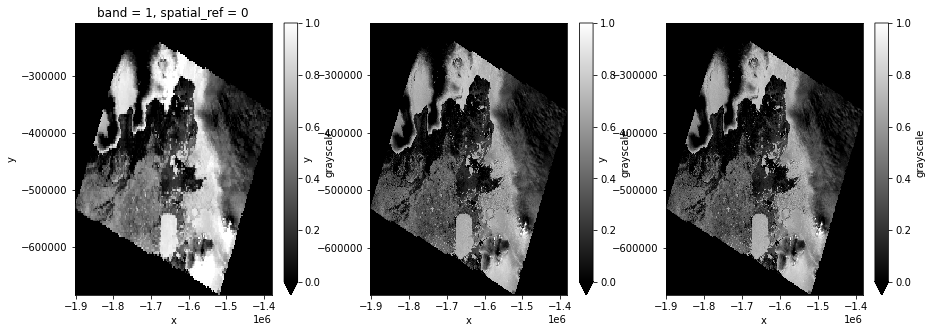

In [5]:
import matplotlib.pyplot as plt
path2gcloud_dir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/PhD/tmp/'

# -- exaample with unitScaled dB values
filename = 'exampleExport_GEE_dB_minmax.tif'
fig,axs=plt.subplots(1,3,figsize=(15,5))
img, windows_1D = img_to_windows(path2gcloud_dir, filename, wsize=15)
img.plot.imshow(ax=axs[0],vmin=0,vmax=1,cmap='gray')

# -- example with original dB valuess
filename = 'exampleExport_GEE_dB.tif'
img, windows_1D = img_to_windows(path2gcloud_dir, filename, wsize=30)
img.plot.imshow(ax=axs[1],vmin=0,vmax=1,cmap='gray')
# print(img.min().values,img.max().values)

# -- example new function
filename = 'exampleExport_GEE_dB.tif'
img = read_img_to_grayscale(path2gcloud_dir, filename)
windows = cut_img_to_windows(img,wsize=15)
img.plot.imshow(ax=axs[2],vmin=0,vmax=1,cmap='gray')
# print(img.min().values,img.max().values)


windows_1D
windows

In [16]:
# img = img.fillna(-999)
# check for nodatavalues in one window:
window = windows.isel(sample=1)
window = window.where(window != -999,np.nan)  # replace all values equal to -999 with np.nan
nodata_val=-999
window
# check if window contains NaN values (then skip) (can be a set nodata-value, or np.nan)
if (window == nodata_val).any():
    # result[n,:] = np.nan*np.ones((1,8))
    print('nodata check')
elif window.isnull().any(): # xarray: check for nodata/nan with .isnull()
    # result[n,:] = np.nan*np.ones((1,8))
    print('nan check')
nanwindow    

nan check


<xarray.DataArray 'gray_image' (x_win: 15, y_win: 15)>
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan]])
Coordinates:
    sample   object (-1886500.0, -239500.0)
Dimensions without coordinates: x_win, y_win
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     grayscale
    window_size:   15

In [98]:
img # value -999 
# windows_1D # value -999 for nan

<xarray.DataArray 'gray_image' (y: 473, x: 520)>
array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]])
Coordinates:
  * y        (y) float64 -2.095e+05 -2.105e+05 ... -6.805e+05 -6.815e+05
  * x        (x) float64 -1.902e+06 -1.9e+06 -1.9e+06 ... -1.384e+06 -1.382e+06
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     grayscale

### apply NERD to check if nan windowss aree processed ocrrectly
 and check pathos.multiprocessing versus python multiprocessing

In [105]:
import nerd

In [106]:

from pathos.multiprocessing import ProcessingPool as Pool
# from multiprocessing import Pool

def do_multiprocess(df,cores=5):
    ''' -------
    MultiProcess NeRD method with Multi Processing
    -----------'''

    start_time = time.time()


    # test_N_samples = 1000
    # df = windows_1D[:,:,:test_N_samples] # (xwin,ywin, N)
    # df = windows_1D # (xwin,ywin, N)

    print('data input', df.shape)

    cores=5; # cores=mp.cpu_count() # intended amount of cores
    print(df.shape[2] % cores)


    # split data in parts (equal to N cores) --> converts to list
    df_split = np.array_split(df, cores, axis=2) 

    # Map function over each split data-part, and stack the parts back together
    with Pool(cores) as pool: # create the multiprocessing pool 
        print('starting pool.map on df_split')
        pool_out = pool.map( nerd.process_img_windows, df_split) # list of arrays with shape (n_samples_split,8)
        df_out = np.concatenate( pool_out ) # array with (samples,8)


    pool.close()
    pool.terminate()
    pool.join()
    # pool.clear() 
    


    print('.. done with pool.map. Output array :',type(df_out),df_out.shape)


    # loop_parall =   (time.time() - start_time)       
    print("--- %s seconds ---" % (time.time() - start_time))


    ''' -------
    Assemble results back to data array
    -----------'''


    results = df_out
    # results = np.vstack(df_out) # (sample,8)
    print(results.shape)
    
    
    da_result = xr.DataArray(results,
                             dims=("sample","out"), 
                             coords=(df["sample"], range(8)), 
                             name="output", 
                             attrs=img.attrs, indexes=img.indexes) 

    da_result.attrs['long_name'] = 'Output NeRD'
    da_result.attrs['descriptions'] = '[theta_1,signal_1, theta_2,signal_2, theta_3,signal_3, theta_4,signal_4]'


    # back to 2D
    da_result = da_result.unstack('sample').transpose("y","x","out")
    print(da_result.shape)
    # da_result.attrs

    # da_result.attrs['window_range(m)'] = window_range
    # da_result.attrs['window_size(px)'] = wsize
    da_result.attrs['crs']='EPSG:3031'
    da_result.attrs
    
    return da_result

In [107]:
da_result = do_multiprocess(windows_1D)


data input (30, 30, 255)
0
starting pool.map on df_split
.. done with pool.map. Output array : <class 'numpy.ndarray'> (255, 8)
--- 16.915616989135742 seconds ---
(255, 8)
(15, 17, 8)


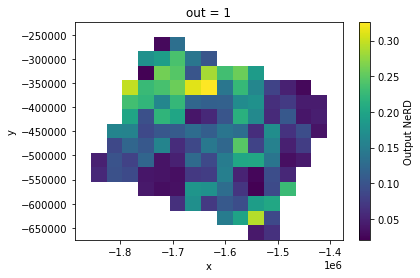

In [111]:
da_result.isel(out=1).plot.imshow()
# window outside of relorb are NaN/-999?

crevSig = da_result.isel(out=1)
# crevsig

#### tesst expoort & impoort of nan-containing dataa --> gaat goed

'/Users/tud500158/Documents/PhD/CrevasseDetection/GoogleEarth/imageExport/fixedFrame/AmundsenBay'

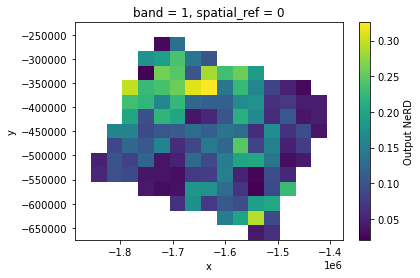

In [118]:
imPath ='/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/PhD/tmp/'
outPath = os.path.join(imPath,'damage_detection')

fname_crevSig = 'test_crevSig_nan.tif'
crevSig = da_result.isel(out=1)

# save data
crevSig.rio.to_raster( os.path.join(outPath, fname_crevSig ))

# read data
da_out = xr.open_dataarray(os.path.join(outPath,fname_crevSig))
da_out
da_out.isel(band=0).plot.imshow()





#### mask nan-containing windwos after processing (not relevant anymore: nan-containing windwos are skipped)

In [33]:
os.getcwd()

'/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/PhD/CrevasseDetection/radonTransform/python/scripts'

PATHS impath
PATHS path2threshold
PATHS threshold_fname
DATA imres
DATA source
DATA img_bounds_min
DATA img_bounds_max
NERD window_size_px
-15


In [85]:
# np.unique(img['x'].diff(dim='x'))[0]
# np.unique(img['y'].diff(dim='y'))[0]

# # img.diff(dim='x')


# # split data in parts (equal to N cores) --> converts to list
# windows_split = np.array_split(windows, 5, axis=2) 

# print(windows.shape[2])
# print(len(windows_split[0]))
# print( 'Hoi {}'.format([part.shape[2] for part in windows_split] ))


1054
15
Hoi [211, 211, 211, 211, 210]


In [14]:
# def mask_nan_containing_windows(xarray_to_mask, windows_1D, min_count=None):
#     # windows_1D should have dims (x_win,y_win,sample)
#     windows_1D_nan_mask = windows_1D.where(windows_1D != -999)  # replace all values equal to -999 with np.nan
    
#     if min_count is None:
#         min_count = windows_1D_nan_mask.attrs['window_size']

#     w_mask_unstack = windows_1D_nan_mask.sum(dim='x_win',skipna=True, min_count=wsize) \
#                         .sum(dim='y_win',skipna=True,min_count=wsize) \
#                         .unstack(dim='sample').transpose("y","x")
    
#     xarray_masked = xarray_to_mask.where(~w_mask_unstack.isnull())
#     return xarray_masked
    

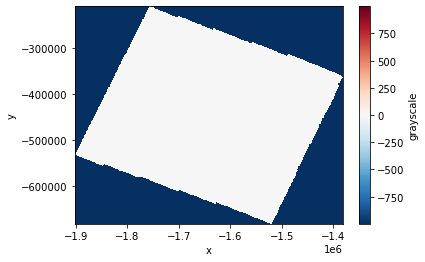

In [24]:
# img.plot.imshow()
# img_mask_windwos = mask_nan_containing_windows(img,windows_1D)
# # img_mask_windwos.plot.imshow()

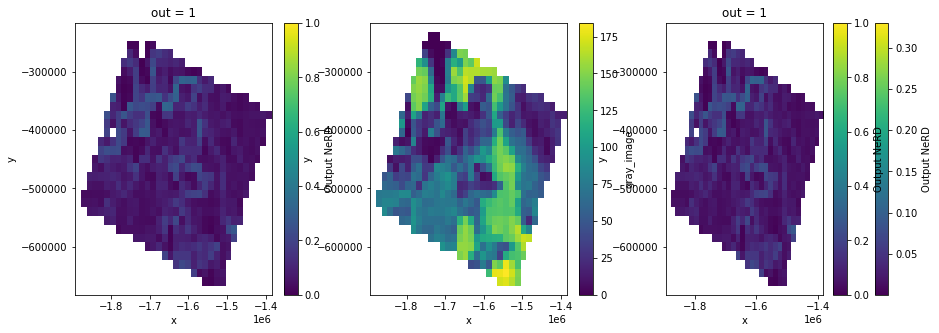

In [17]:
# fig,axs = plt.subplots(1,3, figsize=(15,5))

# da_result.isel(out=1).plot.imshow(ax=axs[0],vmin=0,vmax=1)
# # da_result_fillna

# # get window nanmask

# # windows_1D.where(windows_1D.isnull()).unstack(dim='sample')#.plot.imshow()
# # img.plot.imshow()
# windows_1D_nan_mask = windows_1D.where(windows_1D != -999)  # replace all values equal to -9999 with np.nan
# windows_1D_nan_mask
# wsize = windows_1D_nan_mask.attrs['window_size']
# w_mask_unstack = windows_1D_nan_mask.sum(dim='x_win',skipna=True,min_count=wsize) \
#                     .sum(dim='y_win',skipna=True,min_count=wsize) \
#                     .unstack(dim='sample').transpose("y","x")

# w_mask_unstack.plot.imshow(ax=axs[1])#,vmin=0,vmax=1)


# da_result.isel(out=1).where(~w_mask_unstack.isnull()).plot.imshow(ax=axs[2])#,vmin=0,vmax=1)

# newmask = w_mask_unstack.where(~w_mask_unstack.isnull())
# masked_result = mask_nan_containing_windows(da_result.isel(out=1),windows_1D)
# masked_result.plot.imshow(ax=axs[2],vmin=0,vmax=1)

#### skip nan-containing windwos during processing  
##### Check what hppens to windowsss containing -999
-- nans are reeturned somewher in radoNorm 

In [ ]:
import nerd
# print((windows_1D.isel(sample=0).values==np.array(window)).all())

# select window
# window = windows_1D[ :,:,0 ]
# print(np.array(window))
windows = windows_1D.isel(sample=range(0,3))
result = nerd.process_img_windows(windows, nan_value=-999)


# print(window.shape)
# # # apply function
# # out = radonIce(np.array(window)) # shape (1,1,8)
# # out = nerd.radonIce(window.values) # shape (1,1,8)

# I = np.squeeze(window.values) # -999 vaalues

# # window.where(window.isnull()).where(~w_mask_unstack.isnull())
# window.where(window == -999) #windows_1D.where(windows_1D != -999)  
# if (window == -999).any():
#     print('hoi')
#     out = np.nan*np.ones((1,8))
#     print(out)

# I = np.ones(window.shape)
# I[5,10]=-999
# window = I;
# if (window == -999).any():
#     print('hoi')
# # print(np.unique(I))
# # radon_norm = nerd.radoNorm(I) # [21,180], nan values
# # radon_norm.shape
# # plt.imshow(radon_norm)
# # np.unique(radon_norm)

# # stdRad = np.nanstd(radon_norm,axis=0) # std for each projection, shape [180,]
# # # medRad = median_filter(stdRad,size=3,mode='wrap') # filter signal with median filter (+- 1pixel around center) to remove noise
# # stdRad

In [ ]:

def radoNorm(I,theta=np.arange(0, 180,1)):
    '''Normalised radon transform applied to image windows
    '''
    
    ''' resample image to increase number of pixels'''
    # original grid
    x = np.arange(0,I.shape[0]) 
    y = np.arange(0,I.shape[1])
    grid_x_original, grid_y_original = np.meshgrid(x, y)
    points = np.array((grid_x_original.reshape(grid_x_original.size),grid_y_original.reshape(grid_y_original.size))).T
    values = I.reshape(I.size,1) 

    # new grid
    step = 0.5
    x = np.arange(0,I.shape[0]-step,step) 
    y = np.arange(0,I.shape[1]-step,step)
    grid_x_resampled, grid_y_resampled = np.meshgrid(x, y)
    M, N = np.meshgrid(x, y)

    # interpolate image to new grid
    Iresampled = griddata(points, values, (grid_x_resampled, grid_y_resampled), method='linear') 
    Iresampled = Iresampled.squeeze() # dimensions from [X,Y,1] to [X,Y]

    ''' Initialise output structure '''
    # max length of projection axis rho (equal to window's diagonal):
    rho_full_length = np.ceil( np.sqrt(2)*M.max() ) + 1 # round to integer value; +1 to ensure indexing includes end-value

    # set-up ouptut matrices (filled with NaN)
    radon_norm = np.nan*np.ones((int(rho_full_length),int(len(theta))))
    n_pixels  = np.nan*np.ones((int(rho_full_length),int(len(theta))))
    
    ''' Perform radon transform for every projection angle'''
    for i in theta: 

        ''' Rotate image'''
        
        # rotate frame
        Mrot =  np.cos(np.radians(i)) * (M) + np.sin(np.radians(i))*(N)
        Nrot = -np.sin(np.radians(i)) * (M) + np.cos(np.radians(i))*(N)
        Mnew = Mrot + np.abs( Mrot.min() )
        Nnew = Nrot + np.abs( Nrot.min() )

        # Sort rotated frame to ascending x-axis (Nnew)
    #     Nsort, idx_sort = sort(Nnew); 
        Nnew_array = Nnew.reshape(Nnew.size)
        Nsort = np.sort(Nnew_array)
        idx_sort = np.argsort(Nnew_array) # indices of sorted values

        # Extract Image values that belong to the rotated, sorted frame
        Iresampled_array = Iresampled.reshape(Iresampled.size)
        Inew = Iresampled_array[idx_sort]

        ''' Line integration ''' 

        # Round coordinates to neares integer and bin x-values to each integer value)
        # NB: Nrounded == index_integer_groups_in_N! That was not true in matlab because of indexing starting at 1 vs 0
        Nrounded = np.round(Nsort)
        Nunique, index_integer_groups_in_N = np.unique(Nrounded, return_inverse=True)

        # create dataframe
        df = pd.DataFrame(data={'Nround':Nrounded,'Inew':Inew,'pixel_count':np.ones(Nrounded.size)})

        # Group (/bin) by N-values, sum Image value for each group (resulting in line integration)
        grouped = df.groupby('Nround')
        line_integration_df = grouped.sum()
        normalised_integral = (line_integration_df['Inew']/line_integration_df['pixel_count']).to_numpy()

        ''' Structuring of Output '''

        # Calculate required padding to fill full length projection axis. Set padding equal to left&right 
        n_bins_to_fill = 0;
        n_bins_to_fill = rho_full_length - len(Nunique)
        if n_bins_to_fill > 0: # padding required
            if n_bins_to_fill % 2 == 0: # equal padding left/right
                pad_left  = int(n_bins_to_fill/2);
                pad_right = pad_left
            else: # unequal padding
                pad_left  = int(np.ceil(n_bins_to_fill/2))
                pad_right = int(np.floor(n_bins_to_fill/2))

            radon_norm_theta = np.pad(normalised_integral,(pad_left, pad_right),'constant', constant_values=np.nan )   
            n_pix  = np.pad(line_integration_df['pixel_count'].to_numpy(),(pad_left, pad_right),'constant', constant_values=np.nan )   
            
        else: # no padding
            radon_norm_theta = normalised_integral
            n_pix = line_integration_df['pixel_count'].to_numpy()

        # gather output for each theta in one matrix
        radon_norm[:,i] = radon_norm_theta    
        n_pixels[:,i] = n_pix

#     return radon_norm, n_pixels
    return radon_norm




## Check reading of config file

In [11]:
import os
import configparser

imPath = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/S1_SAR/relorbs/'
outPath = os.path.join(imPath,'damage_detection')
os.path.join(outPath, 'geotiffs_python/')

os.path.isdir(outPath)
if not os.path.isdir(outPath):
    os.mkdir(outPath)
    print('making dir ',outPath)

path2save = os.path.join(outPath, 'geotiffs_python/')
if not os.path.isdir(path2save):
    os.mkdir(path2save)
    print('making dir ',path2save)
    
    
configPath = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/PhD/CrevasseDetection/radonTransform/config_files'
configFile = 'config_S1_relorbs_py.ini'
config = configparser.ConfigParser()
config.read(os.path.join(configPath,configFile))

imPath = config['PATHS']['imPath']    # read as string
path2threshold = config['PATHS']['path2threshold']
threshold_fname= config['PATHS']['threshold_fname']
imRes = int(config['DATA']['imRes'])
source = config['DATA']['source']
dbmin = int(config['DATA']['img_bounds_min'])
dbmax = int(config['DATA']['img_bounds_max'])
wsize = int(config['NERD']['window_size_px'])
# print(dbmin)
print(imPath)
os.listdir(imPath)
imList= sorted([file for file in os.listdir(imPath) if file.endswith('.tif')])
imList

/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/PhD/tmp/


['exampleExport_3000m.tif',
 'exampleExport_GEE_3000m.tif',
 'exampleExport_GEE_dB.tif',
 'exampleExport_GEE_dB_minmax.tif',
 'exampleExport_relorb_1000m.tif',
 'exampleExport_relorb_30m.tif',
 'exampleExport_tile50.tif',
 'exampleExport_tile50_1000m.tif',
 'exampleExport_tile50_30m.tif',
 'newcopy.tif',
 'test_export_funct.tif']

In [77]:


configPath = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/PhD/CrevasseDetection/radonTransform/config_files'
configFile = 'config_S1_relorbs_py.ini'
config = configparser.ConfigParser()
config.read(os.path.join(configPath,configFile))

path2files = config['PATHS']['path2files']
my_bucket = config['PATHS']['gcloud_bucket']

mode = config['DATA']['mode']
# orbit = 'ASCENDING'
t_strt = config['DATA']['t_strt']
t_end = config['DATA']['t_end']
vismin = int(config['DATA']['img_bounds_min'])
vismax = int(config['DATA']['img_bounds_max'])
bnds = config['DATA']['bnds'] 
CRS = config['DATA']['CRS']
scale = int(config['DATA']['imRes']) # test scale
clip_coast = True if config['DATA']['clip_coast'] == 'True' else False


try:
    tileNums = config['DATA']['tileNums']
    tileNums = [int(t) for t in tileNums.split()]
except:
    # no tileNums specified
    tileNums = None


<class 'bool'>
True [False]


#### make check if threshold check is included

In [30]:
import json
print(path2threshold)
print(threshold_fname)
print(imPath)
window_range = wsize*imRes
window_range = 1000
# convert crevSig to dmg
with open(os.path.join(path2threshold,threshold_fname), 'r') as fp:
    threshold_dict = json.load(fp)

try: # check if runs with error
    threshold = threshold_dict[source]['window_size(m)_threshold'][str(window_range)]
except KeyError: # handle error
    print('Warning: Threshold could not be loaded: window_range {}m not in dict for source {} \n' 
          '--> threshold set to None, dmg not calculated'.format(window_range,source))
    threshold = None # set threshold to None
except:
    print('Warning: Threshold could not be loaded for some reason. Set to None')
    threshold = None
else:
    print('.. Loaded  threshold {} for window_range {}m for source {}. Calculate and save dmg'.format(threshold,window_range,source))

if threshold is not None:
    print('calc dmg')

/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/PhD/CrevasseDetection/radonTransform/variables/
dmg_threshold_dictionary.json
/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/PhD/tmp/
.. Loaded  threshold 0.034 for window_range 1000m for source S1. Calculate and save dmg
calc dmg


### output to geotiff


In [90]:
import xarray as xr
import rasterio as rio
import rioxarray as rioxr

In [124]:
# fname_out = imName[:-4] + '_output_' + str(wsize) + 'px' # [imName_output_Npx]
imPath

'/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/PhD/tmp/'

In [129]:
# read netCDF and make geotiff

outPath = os.path.join(imPath,'damage_detection')
fname_out = 'test_export_funct_output_100px'
fname_out = 'relorb_S1A_EW_GRDM_1SDH_20200606T041956_20200606T042050_032891_03CF54_A051_4000m_output_100px'

da_out = xr.open_dataarray(os.path.join(outPath,fname_out +'.nc'))

path2save = os.path.join(outPath,'geotiffs_python')

fname_crevSig = fname_out + '_crevSig'
fname_alpha_c = fname_out + '_alphaC'

fname_dmg = fname_out + '_dmg'

# fname_Dalpha= fname_out + '_Dalpha'
print(da_out)
crevSig = da_out.isel(out=1)
print(crevSig)
crevSig.rio.to_raster( os.path.join(path2save, fname_crevSig + '.tif'))

# if threshold is not None:
#     dmg.where(dmg>0).rio.to_raster( os.path.join(path2save, fname_dmg + '.tif'))
# delta_alpha.where(dmg>0).rio.to_raster(os.path.join(path2save, fname_Dalpha + '.tif'))

<xarray.DataArray 'output' (y: 1, x: 1, out: 8)>
array([[[nan, nan, nan, nan, nan, nan, nan, nan]]])
Coordinates:
  * out      (out) int32 0 1 2 3 4 5 6 7
  * x        (x) float64 -1.502e+06
  * y        (y) float64 -6.1e+05
Attributes:
    long_name:        Output NeRD
    descriptions:     [theta_1,signal_1, theta_2,signal_2, theta_3,signal_3, ...
    window_range(m):  400000
    window_size(px):  100
    crs:              EPSG:3031
<xarray.DataArray 'output' (y: 1, x: 1)>
array([[nan]])
Coordinates:
    out      int32 1
  * x        (x) float64 -1.502e+06
  * y        (y) float64 -6.1e+05
Attributes:
    long_name:        Output NeRD
    descriptions:     [theta_1,signal_1, theta_2,signal_2, theta_3,signal_3, ...
    window_range(m):  400000
    window_size(px):  100
    crs:              EPSG:3031
